In [1]:
import os
import os.path as path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la


from src.structured_random_features.src.models.weights import V1_weights


In [2]:
#rf, snr, dim = load_V1_natural_images(centered = True);

In [86]:
# 1. Generate random V1 weights

numCell = 100
dim = (30, 30)
cellSize = 3
sparseFreq = 3

W = V1_weights(numCell, dim, cellSize, sparseFreq)

In [87]:
print(W.shape)

(100, 900)


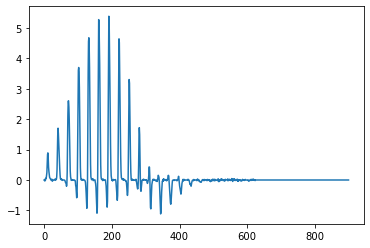

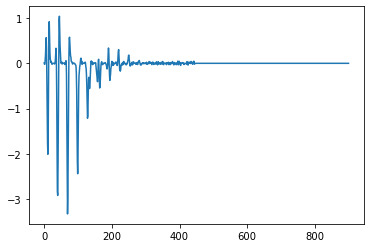

In [88]:
plt.plot(W[1])
plt.show()
plt.plot(W[2])

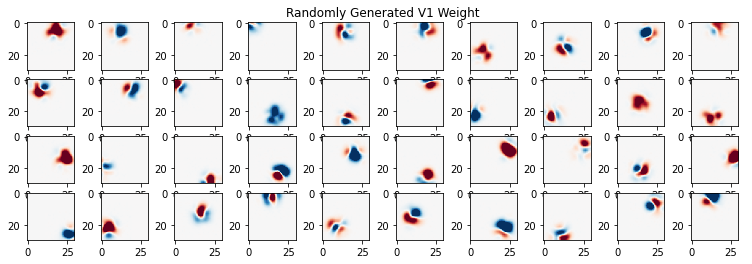

In [89]:
# 2. Plot those V1 weights

fig = plt.figure(figsize = (13, 4))
plt.title('Randomly Generated V1 Weight')
plt.axis('off')
for i in range(40):
    ax = fig.add_subplot(4, 10, i+1)
    cell_rf = W[i]
    cell_rf = cell_rf.reshape(dim)
    plt.imshow(cell_rf, cmap="RdBu")
    plt.clim([-3, 3])
    #plt.axis('off')

In [90]:
W.shape

(100, 900)

In [91]:
# Wx = (lambda)Ux * G
# min ||y-G(Lambda)s||^2 + lambda||s||.

In [92]:
# load size dim image
# reshape to dim[0] * dim[1]
# do:
#W @ x

In [93]:
from PIL import Image, ImageOps

(64, 104)


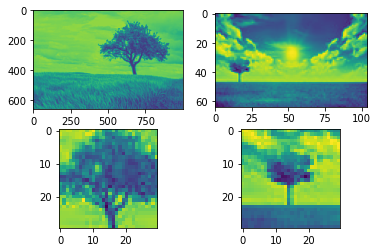

In [94]:
fig = plt.figure()

img_Original1 = Image.open("image/tree.jpg") # Original size(1000, 662)
img_Original1 = ImageOps.grayscale(img_Original1)

img_Original2 = Image.open("image/tree3.jpg") # Original size(64, 104)
img_Original2 = ImageOps.grayscale(img_Original2)
print(np.asarray(img_Original2).shape)

# took 30 X 30 pixel part of tree image at about coord(650, 260)
img1 = Image.open("image/tree_part1.jpg")
img1 = ImageOps.grayscale(img1)
imgArr1 = np.asarray(img1)


# Substitution image in case
img2 = Image.open("image/tree3_part.jpg")
img2 = ImageOps.grayscale(img2)
imgArr2 = np.asarray(img2)

#Show image
ax = fig.add_subplot(2, 2, 1)
plt.imshow(img_Original1)

ax = fig.add_subplot(2, 2, 2)
plt.imshow(img_Original2)

ax = fig.add_subplot(2, 2, 3)
plt.imshow(img1)

ax = fig.add_subplot(2, 2, 4)
plt.imshow(img2)

In [95]:
n = 30 # image in (n, n) dimension

imgArr1 = imgArr2.flatten().reshape((900, 1)) #flattens & resize image array into 1 dimension where (900, 1)
print("ImgArr shape: ", imgArr1.shape)

ImgArr shape:  (900, 1)


## From y = CΨs, (While considering W ~= C
#### 1.Get y
#### 2. Do WΨ to get theta
#### 3. Lasso to fit thetha with y and get sparse s
#### 4. Reconstruct image

In [96]:
# 1. Some measurement y
y = W @ imgArr1
y = y.squeeze()

In [97]:
from scipy import fftpack as fft
from sklearn.linear_model import Lasso

In [98]:
## 2. WΨ
theta = fft.dctn(W.reshape(numCell, n, n), norm = 'ortho')
theta = theta.reshape(numCell, n*n)
theta.shape


(100, 900)

Text(0.5, 1.0, 'W')

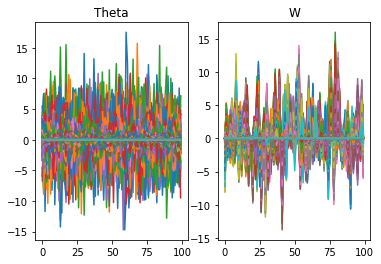

In [99]:
# Check difference between W and theta
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
plt.plot(theta)
plt.title("Theta")

ax = fig.add_subplot(1, 2, 2)
plt.plot(W)
plt.title("W")


(900,)


C:\Users\qkstn\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43816077.89102864, tolerance: 9318553.380127273
  model = cd_fast.enet_coordinate_descent(


Text(0.5, 1.0, 'sparse s')

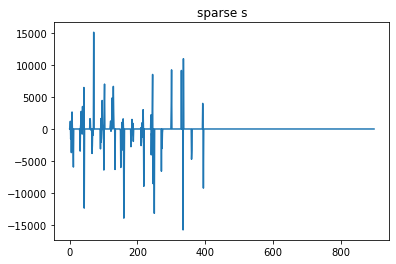

In [100]:
# Normalize data with lasso
mini = Lasso(alpha = 1*numCell)
mini.fit(theta, y)
s = mini.coef_
print(s.shape)
plt.plot(s)
plt.title('sparse s')

In [101]:
# 4. Reform image
reform = fft.idctn(s.reshape(n, n))

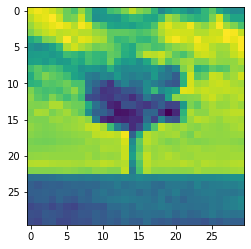

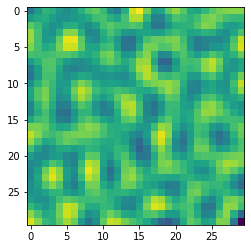

In [102]:
# Show reconstructed image
plt.imshow(img2)
plt.show()
plt.imshow(reform)

In [103]:
#Tried to change number of cells, alpha values, to 1 dimensional fft, but they dont work